In [1]:
# Standard library imports
import os
import sys
import warnings
import math

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import mat73
import pandas as pd
import rpy2.robjects as robjects
from scipy.signal import butter, find_peaks, lfilter
from sklearn.model_selection import train_test_split

# Local imports
from src.features.preprocessing import *
from src.visualization.data_vis import *

# Notebook magic
%matplotlib inline

In [2]:
# Filter 
filter_order = 2
theta_sampling_freq = 1250
lowcut = 4 / (theta_sampling_freq*0.5)
highcut = 12 / (theta_sampling_freq*0.5)
downsample_coefficient = 4

# Theta epoch extraction
trial_duration = 4 # seconds
trial_N = int(theta_sampling_freq*trial_duration) # Number of data points in each trial based on theta sampling frequency

# KDE  
bandwidth = 0.02
kde_domain = [0, 4]
cut = 3
kde_domain_N = trial_N

# DFA 
DFA_window = 0.375 # seconds

In [3]:
file_data = mat73.loadmat('/'.join([os.getcwd(), 'data', 'raw', "fitted_data_mjc58-2301-0117.mat"]))

# Assign spike data constructs
qspike = file_data['qspike'] # trial spike times

pyrspike = file_data['pyrspike'] # all pyramidal spike times and labels
intspike = file_data['intspike'] # all interneuron spike times and labels

qpspike = shift_qspike(qspike, file_data['BP']) # trial spike times aligned to maximize likelihood estimate

# Assign theta LFP vectors
theta = file_data['lfp']
theta_time_axis = file_data['time_eeg']

# Determine indices in theta_time_axis where each trial begins
trial_shifts = (file_data['BP']*file_data['fs2']).astype(int)
unshifted_trial_start_indices = (file_data['tp']*file_data['fs2']).astype(int)
trial_start_indices = unshifted_trial_start_indices - trial_shifts

# Extract relevant structures
pyr_com_trials, pyr_sep_trials, pyr_com_neuron_labels, pyr_sep_neuron_labels, pyr_sep_trial_labels = prep_pyr_qpspike(qpspike, intspike, pyrspike)

# Create and apply Butterworth bandpass filter
b, a = butter(filter_order, [lowcut, highcut], btype='band') # The IIR
theta_filtered = lfilter(b, a, theta) # Apply the filter

trial_theta_x = np.zeros((trial_start_indices.size, trial_N), dtype=float) # Columns are data, rows are different trials
trial_theta_y = np.zeros((trial_start_indices.size, trial_N), dtype=float) # Columns are data, rows are different trials

# Extract complete epochs
for trial_i, start_i in enumerate(trial_start_indices):
    trial_theta_x[trial_i, :] = theta_time_axis[start_i:start_i + trial_N]
    trial_theta_y[trial_i, :] = theta_filtered[start_i:start_i + trial_N]

Pyramidal neurons [38.0, 66.0, 82.0, 86.0, 90.0] absent from qpspike.


In [ ]:
# Initialize some constructs and parameters
plt.rcParams['figure.dpi'] = 300 # Increase inline image resolution

# These lists will allow separation of pyramidal and interneuron data
pyr_neuron_spike_times = [] 
int_neuron_spike_times = []

time_axis = np.linspace(0, 4, num=trial_theta_y.shape[1]) # Time axis to be used for all plots

# Loop over each neuron ID once
for neuron_ID in list(set(qpspike[:, 2])):

    if neuron_ID in list(set(pyrspike[:, 0])):
        rows = np.where(qpspike[:, 2] == neuron_ID)[0] # Rows with the correct neuron ID
        trial_coords = (rows, np.ones((rows.shape[0],), dtype=int)) # The column containing the corresponding spike times is indexed 1
        pyr_neuron_spike_times.append(qpspike[trial_coords]) # Pull out the spike times for the current pyramidal

    if neuron_ID in list(set(intspike[:, 0])):
        rows = np.where(qpspike[:, 2] == neuron_ID)[0] # Rows with the correct neuron ID
        trial_coords = (rows, np.ones((rows.shape[0],), dtype=int)) # The column containing the corresponding spike times is indexed 1
        int_neuron_spike_times.append(qpspike[trial_coords]) # Pull out the spike times for the current interneuron


kde_x, pyr_kde_y = r_spike_kde(pyr_neuron_spike_times, bandwidth, trial_theta_y.shape[1], kde_domain) # Get the kde for the individual pyramidals
kde_x, int_kde_y = r_spike_kde(int_neuron_spike_times, 0.005, trial_theta_y.shape[1], kde_domain) # Get the kde for the individual interneurons -- much shorter bandwidth for the high freq

# Normalize amplitude of pyramidal kernel density estimates
pyr_norm_kde_y = np.empty((len(pyr_kde_y), trial_theta_y.shape[1]))
for i, kde in enumerate(pyr_kde_y):
    pyr_norm_kde_y[i, :] = kde/np.amax(kde) # Don't need absolute value since all elements >= 0

# Normalize amplitude of interneuron kernel density estimates
int_norm_kde_y = np.empty((len(int_kde_y), trial_theta_y.shape[1]))
for i, kde in enumerate(int_kde_y):
    int_norm_kde_y[i, :] = kde/np.amax(kde)

# Normalize LFP and shift the baseline
for trial_theta_i in range(trial_theta_y.shape[0]):
    trial_theta_y[trial_theta_i, :] = (trial_theta_y[trial_theta_i, :] - np.mean(trial_theta_y[trial_theta_i, :]))/np.amax(np.abs(trial_theta_y[trial_theta_i, :]))

# Figure boilerplate
plt.close()
fig, axes = plt.subplots(3, 1, sharex=True)
fig.patch.set_alpha(0.0)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Plot spike times
axes[0].eventplot(int_neuron_spike_times, color='k', lineoffsets=1.6, linewidths=0.3)
axes[0].eventplot(pyr_neuron_spike_times, color='k', lineoffsets=1.6, linewidths=0.3)

# Plot the pyramidal kde data
for kde in pyr_norm_kde_y:
    axes[1].plot(time_axis, kde, linewidth=0.2, color='b') # individual neurons
axes[1].plot(time_axis, np.mean(pyr_norm_kde_y, axis=0), color='k', linewidth=1.0) # average kde

# Plot interneuron kde data
for kde in int_norm_kde_y:
    axes[1].plot(time_axis, kde, linewidth=0.2, color='g') # individual neurons
axes[1].plot(time_axis, np.mean(int_norm_kde_y, axis=0), color='k', linewidth=1.0) # average kde

# Plot LFP data
for trial_theta_i in range(trial_theta_y.shape[0]):
    axes[2].plot(time_axis, trial_theta_y[trial_theta_i, :], linewidth=0.2, color='r') # Individual trials
axes[2].plot(time_axis, np.mean(trial_theta_y, axis=0), color='k', linewidth=1.0) # average across trials 

axes[0].set_ylabel('Spike raster')
axes[1].set_ylabel('KDE')
axes[2].set_ylabel('LFP')
axes[2].set_xlabel('Time ($s$)')

plt.show()

In [4]:
# Boolean classification vector
onehot_vector = np.zeros((len(pyr_sep_trials), 2), dtype=int)
trial_kde = np.empty((len(pyr_sep_trials), trial_N), dtype=float)
trial_theta = np.empty((len(pyr_sep_trials), trial_N), dtype=float)

# Iterate over each individual trial
for i, trial_data in enumerate(pyr_sep_trials):
    
    trial_i = int(pyr_sep_trial_labels[i] - 1) # Trial index is one less than trial label
    active_domain_dur = (trial_data[-1] + cut*bandwidth) - (trial_data[0] - cut*bandwidth)
    active_domain_N = int(file_data['fs2']*active_domain_dur)

    kde_x, kde_y = r_spike_kde([trial_data], bandwidth, kde_domain_N, kde_domain)

    detuning = dominant_frequency_analysis(
        kde_y[0],
        trial_theta_x[trial_i, :],
        trial_theta_y[trial_i, :],
        DFA_window,
        file_data['fs2']
    )

    # Change classification from default when appropriate
    if detuning > 0:
        onehot_vector[i, 0] = 1
    else:
        onehot_vector[i, 1] = 1
    
    # Store trial data
    trial_kde[i, :] = kde_y[0]
    trial_theta[i, :] = trial_theta_y[trial_i, :]

# Downsample and copy data
X_kde = trial_kde[:, ::downsample_coefficient] # 1249 -> 625 Hz
X_theta = trial_theta_y[:, ::downsample_coefficient] # 1250 -> 625 Hz
Y = onehot_vector

# Normalize kde
for trial_row in range(X_kde.shape[0]):
    X_kde[trial_row, :] = (X_kde[trial_row, :]/np.amax(X_kde[trial_row, :]))

In [ ]:
# Visualization control parameters
start = 90
end = 10
plt.rcParams['figure.dpi'] = 100

# Visualization-specific contstructs
neuron_labels = list(set(pyr_com_neuron_labels))
x_axis = np.linspace(0, 4, num=trial_N)
mean_trial_theta = np.mean(trial_theta_y, axis=0) # Mean LFP across (maximum-likelihood shifted) trials

# Loop over all neuron IDs
for i, neuron in enumerate(neuron_labels[start:]):

    # Initialize raster data with the trial-combined spike times
    raster_data = [pyr_com_trials[i]]
    color_list = ['r'] # ... which we'll color red
    for j in np.where(np.array(pyr_sep_neuron_labels) == neuron)[0]:
        raster_data.append(pyr_sep_trials[j]) # ... then append the individual trial spike times one-by-one
        color_list.extend(['k']) # ... and color each in black (later we'll color these to indicate those which exhibit phase precession)

    kde_x, kde_y = r_spike_kde([pyr_com_trials[i]], bandwidth, kde_domain_N, kde_domain) # Get the kde for the combined data
    kde_y = kde_y[0] 
    fs = int(trial_N/4) # Lazily ensure sampling frequency is correct
    kde_maxima = find_peaks(kde_y, height=0.2*np.amax(kde_y), distance=0.06*fs)[0] # Get the maxima of the combined data kde (MAGIC NUMBERS)

    print(f'Pyramidal ID: {int(neuron)}')

    # Plot the stuff
    plt.close()
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.patch.set_alpha(0.0)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0].eventplot(raster_data, colors=color_list, lineoffsets=1.6)
    axes[0].set_ylabel('Trial index')
    axes[1].plot(x_axis, kde_y, color='k', linewidth=1.5)
    axes[1].scatter(x_axis[kde_maxima], kde_y[kde_maxima], color='deeppink', s=10, zorder=1)
    axes[1].set_ylabel('Combined data KDE')
    axes[2].plot(x_axis, mean_trial_theta, linewidth=1.5)
    axes[2].scatter(x_axis[kde_maxima], mean_trial_theta[kde_maxima], color='deeppink', s=10, zorder=1)
    axes[2].set_ylabel('Mean LFP')

    plt.show()

Neuron: 30.0, Label: Null
Trial: 8.0
Trial Index: 7


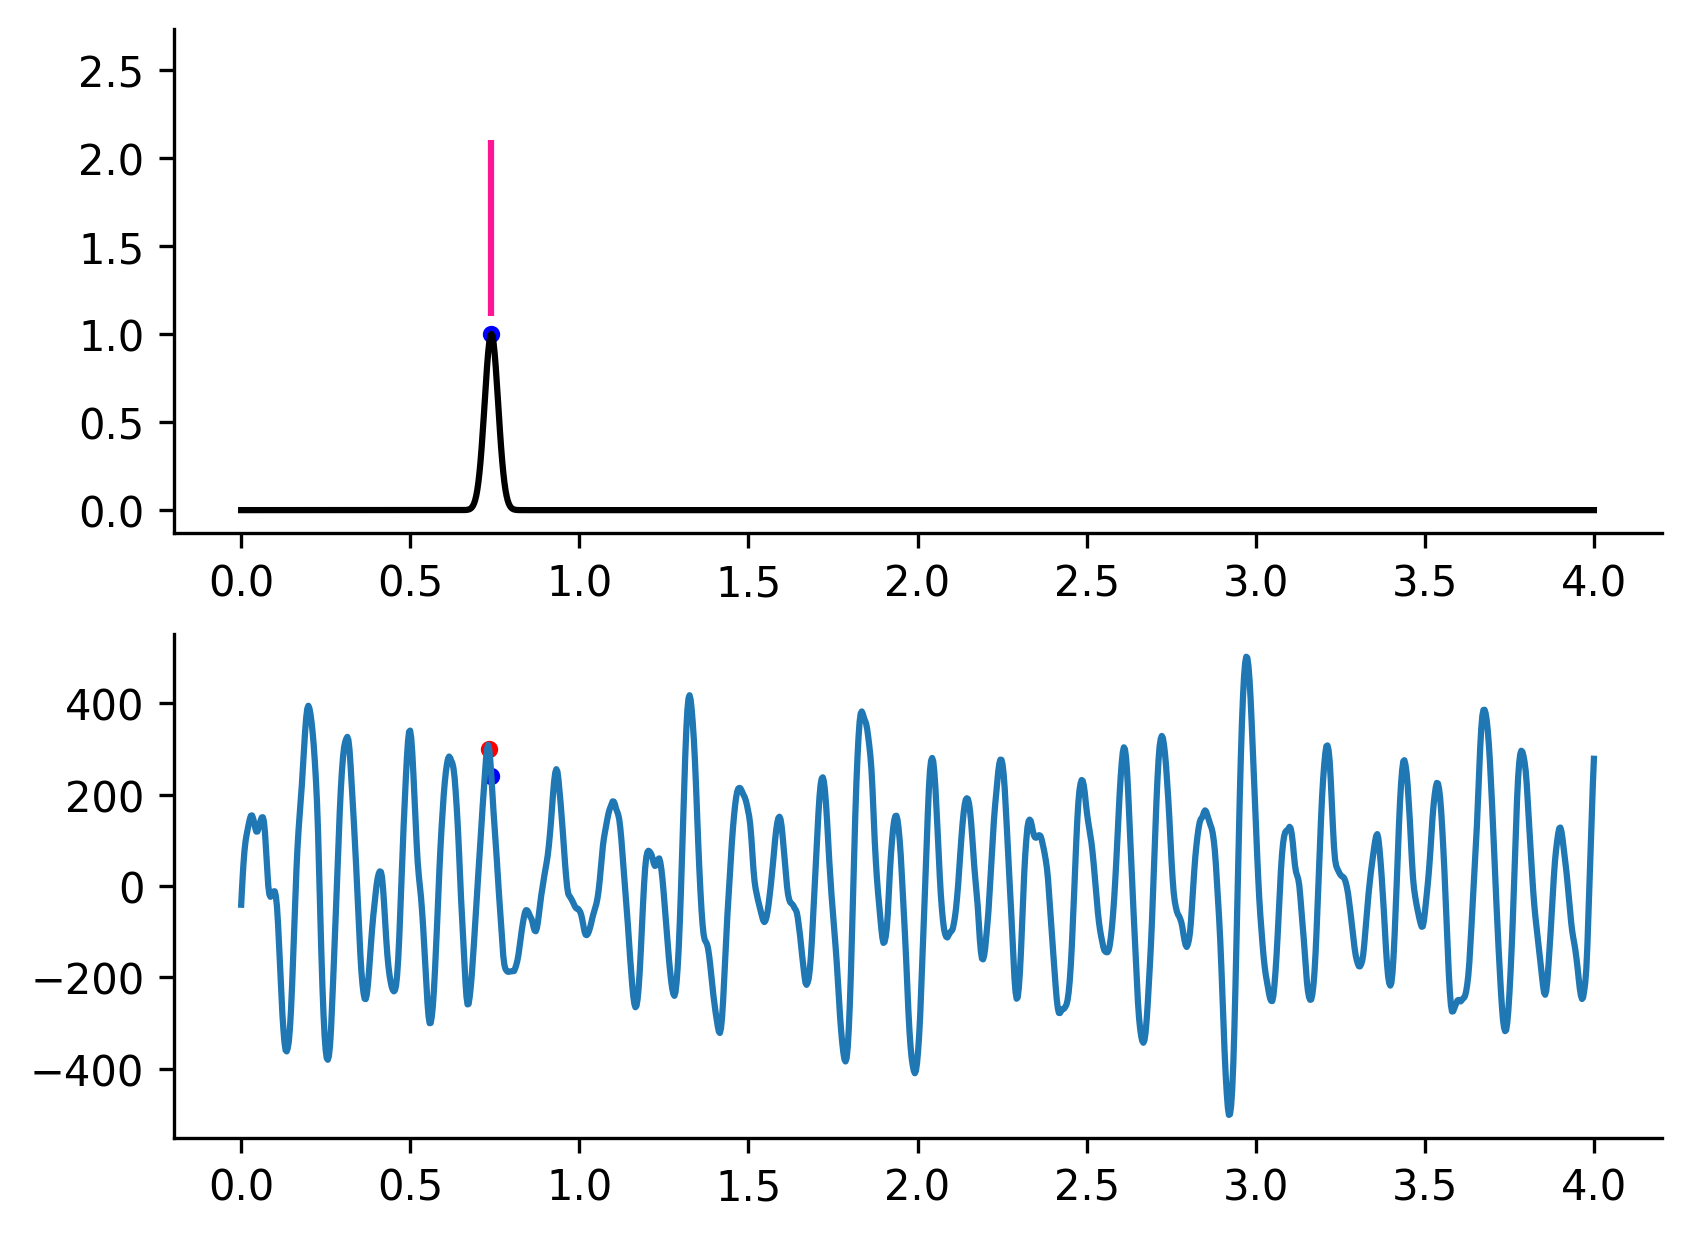

Neuron: 30.0, Label: Null
Trial: 10.0
Trial Index: 9


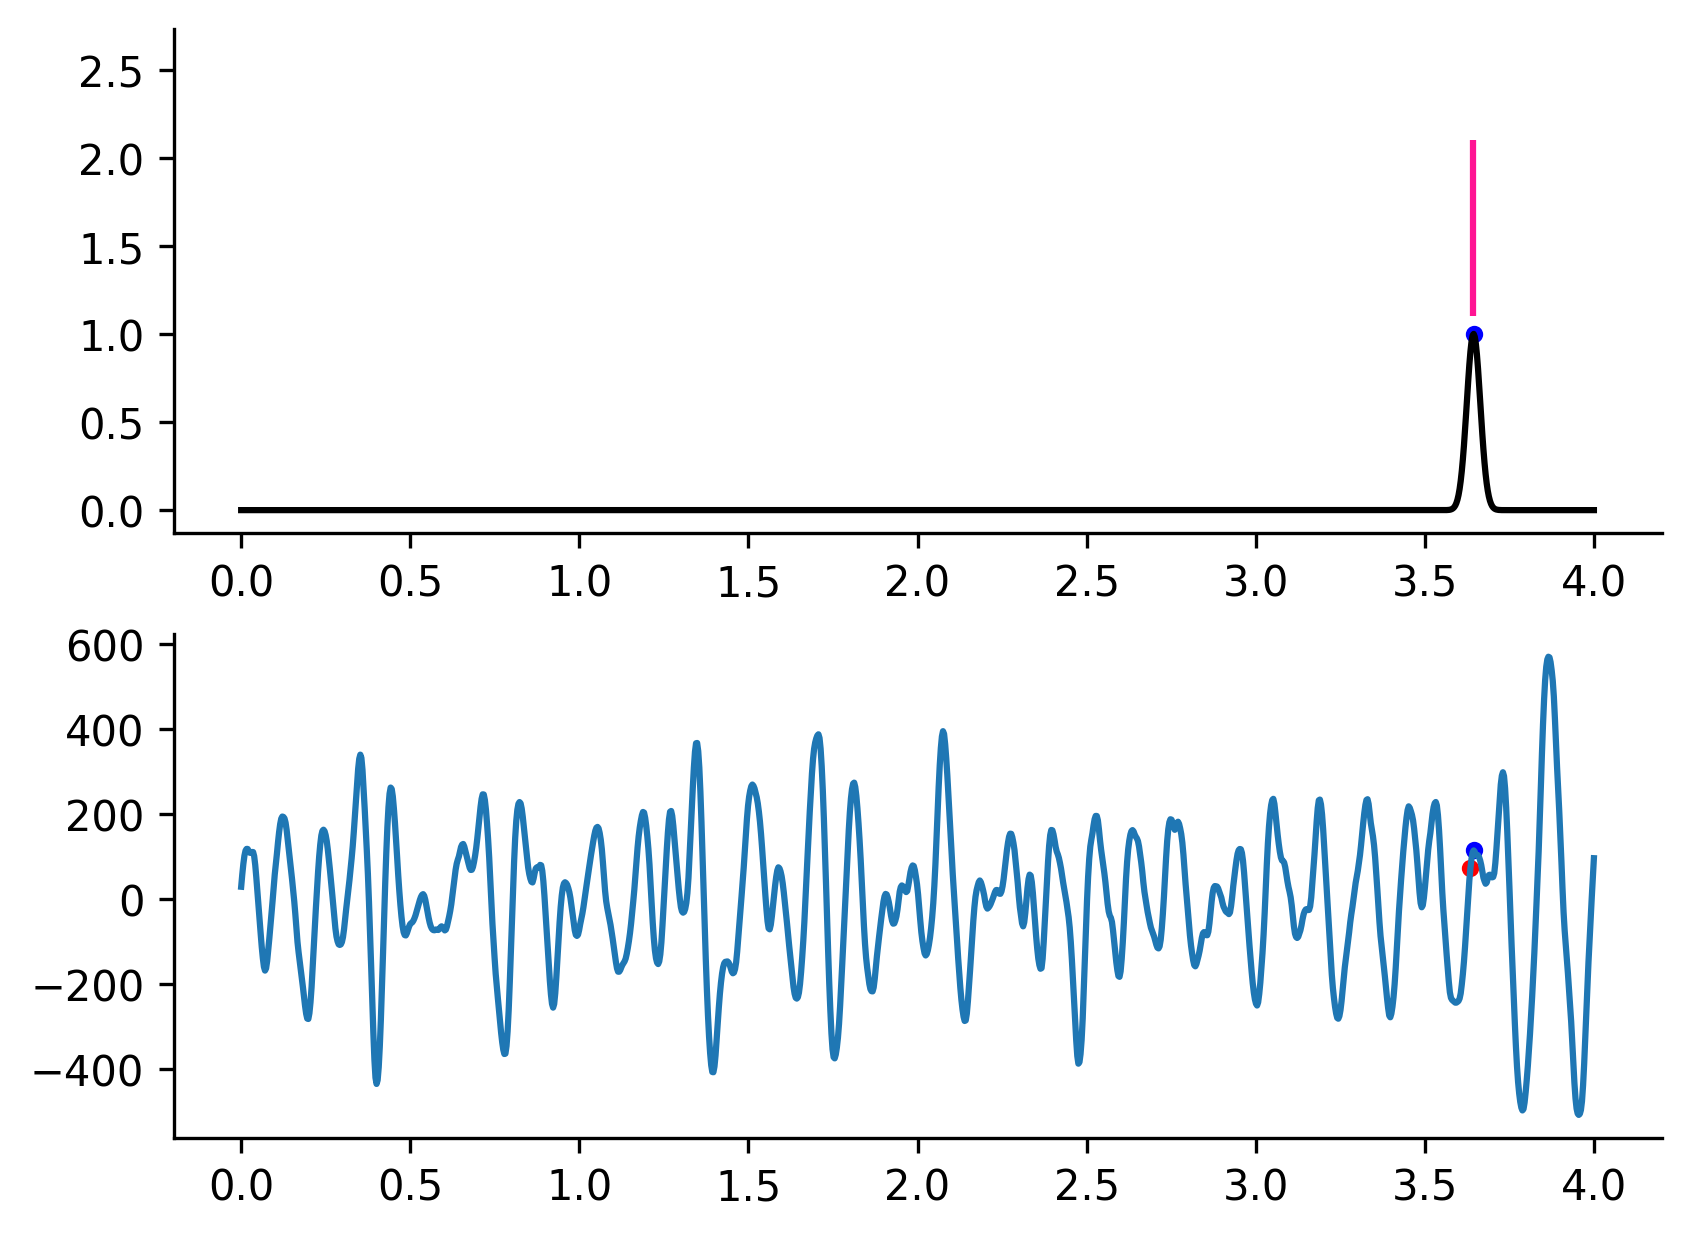

Neuron: 30.0, Label: Null
Trial: 15.0
Trial Index: 14


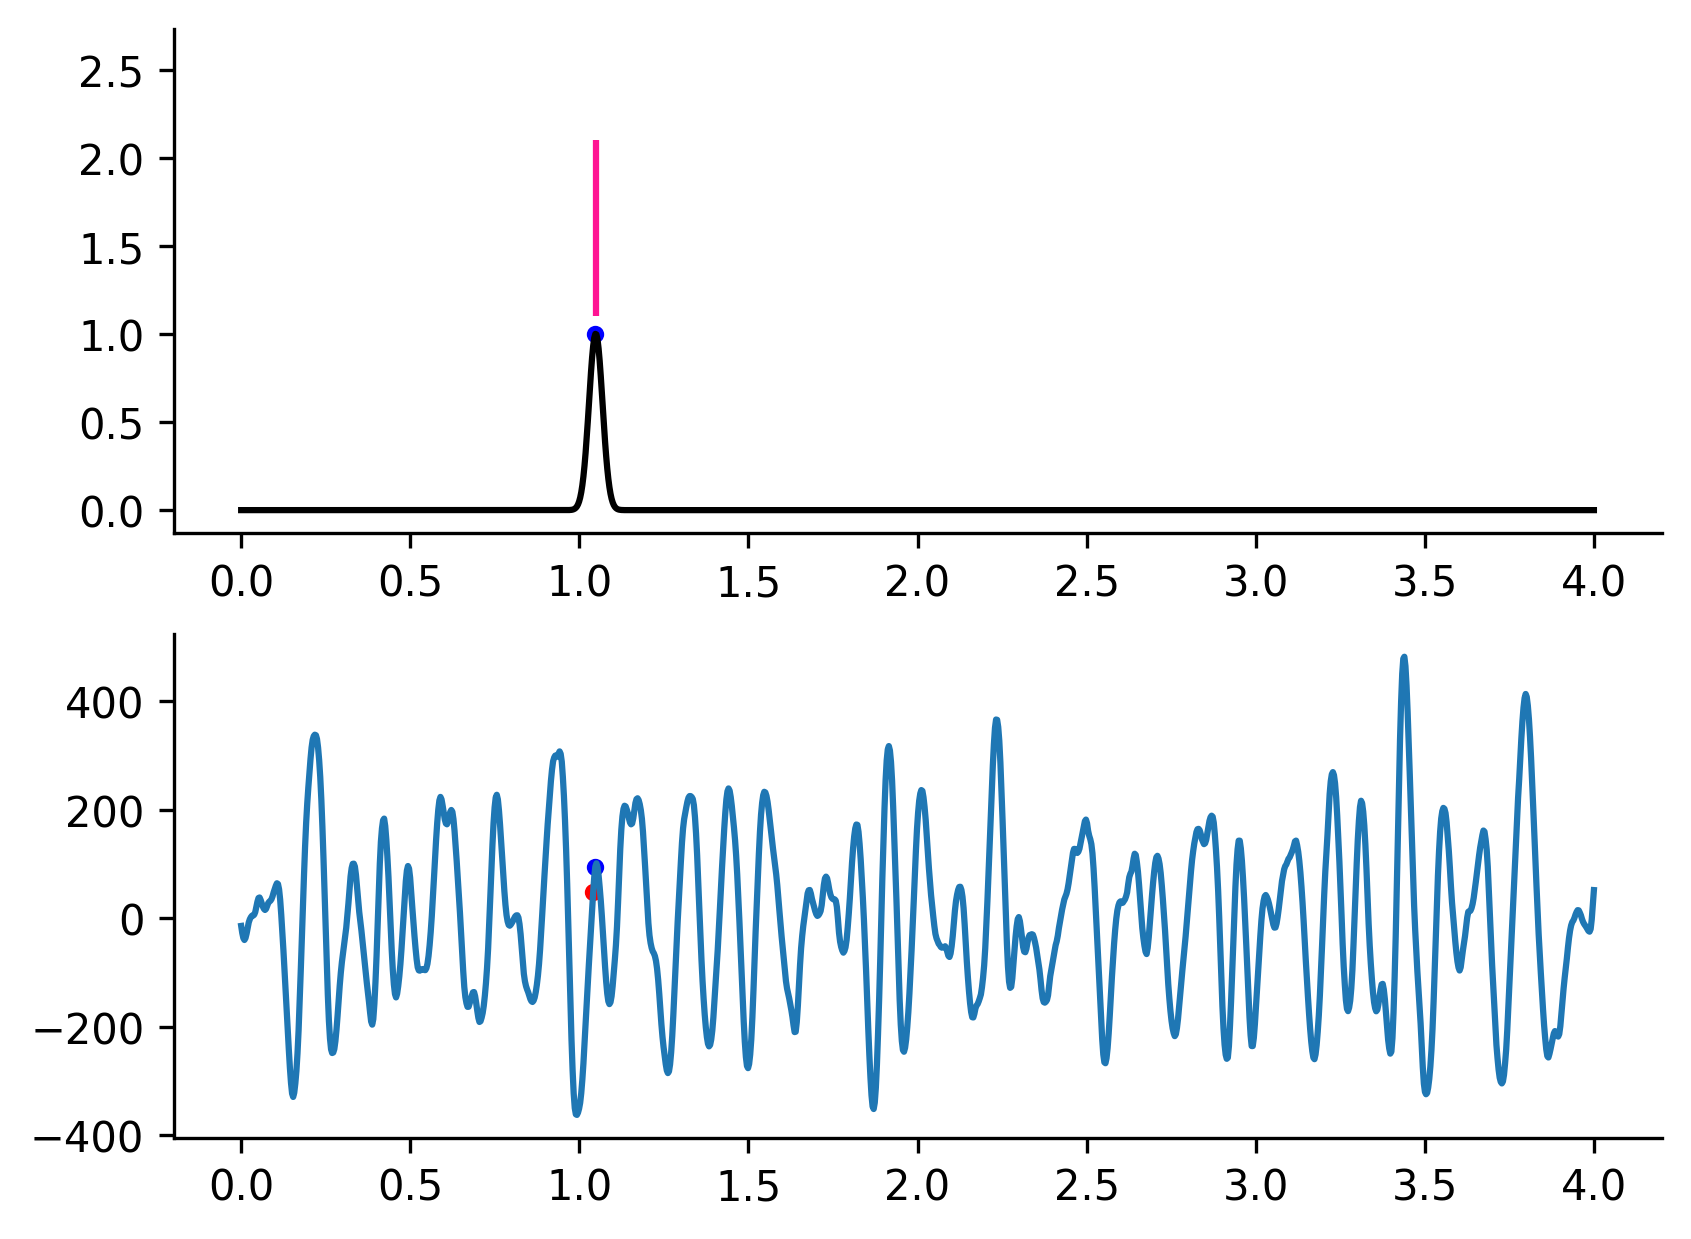

Neuron: 30.0, Label: Null
Trial: 25.0
Trial Index: 24


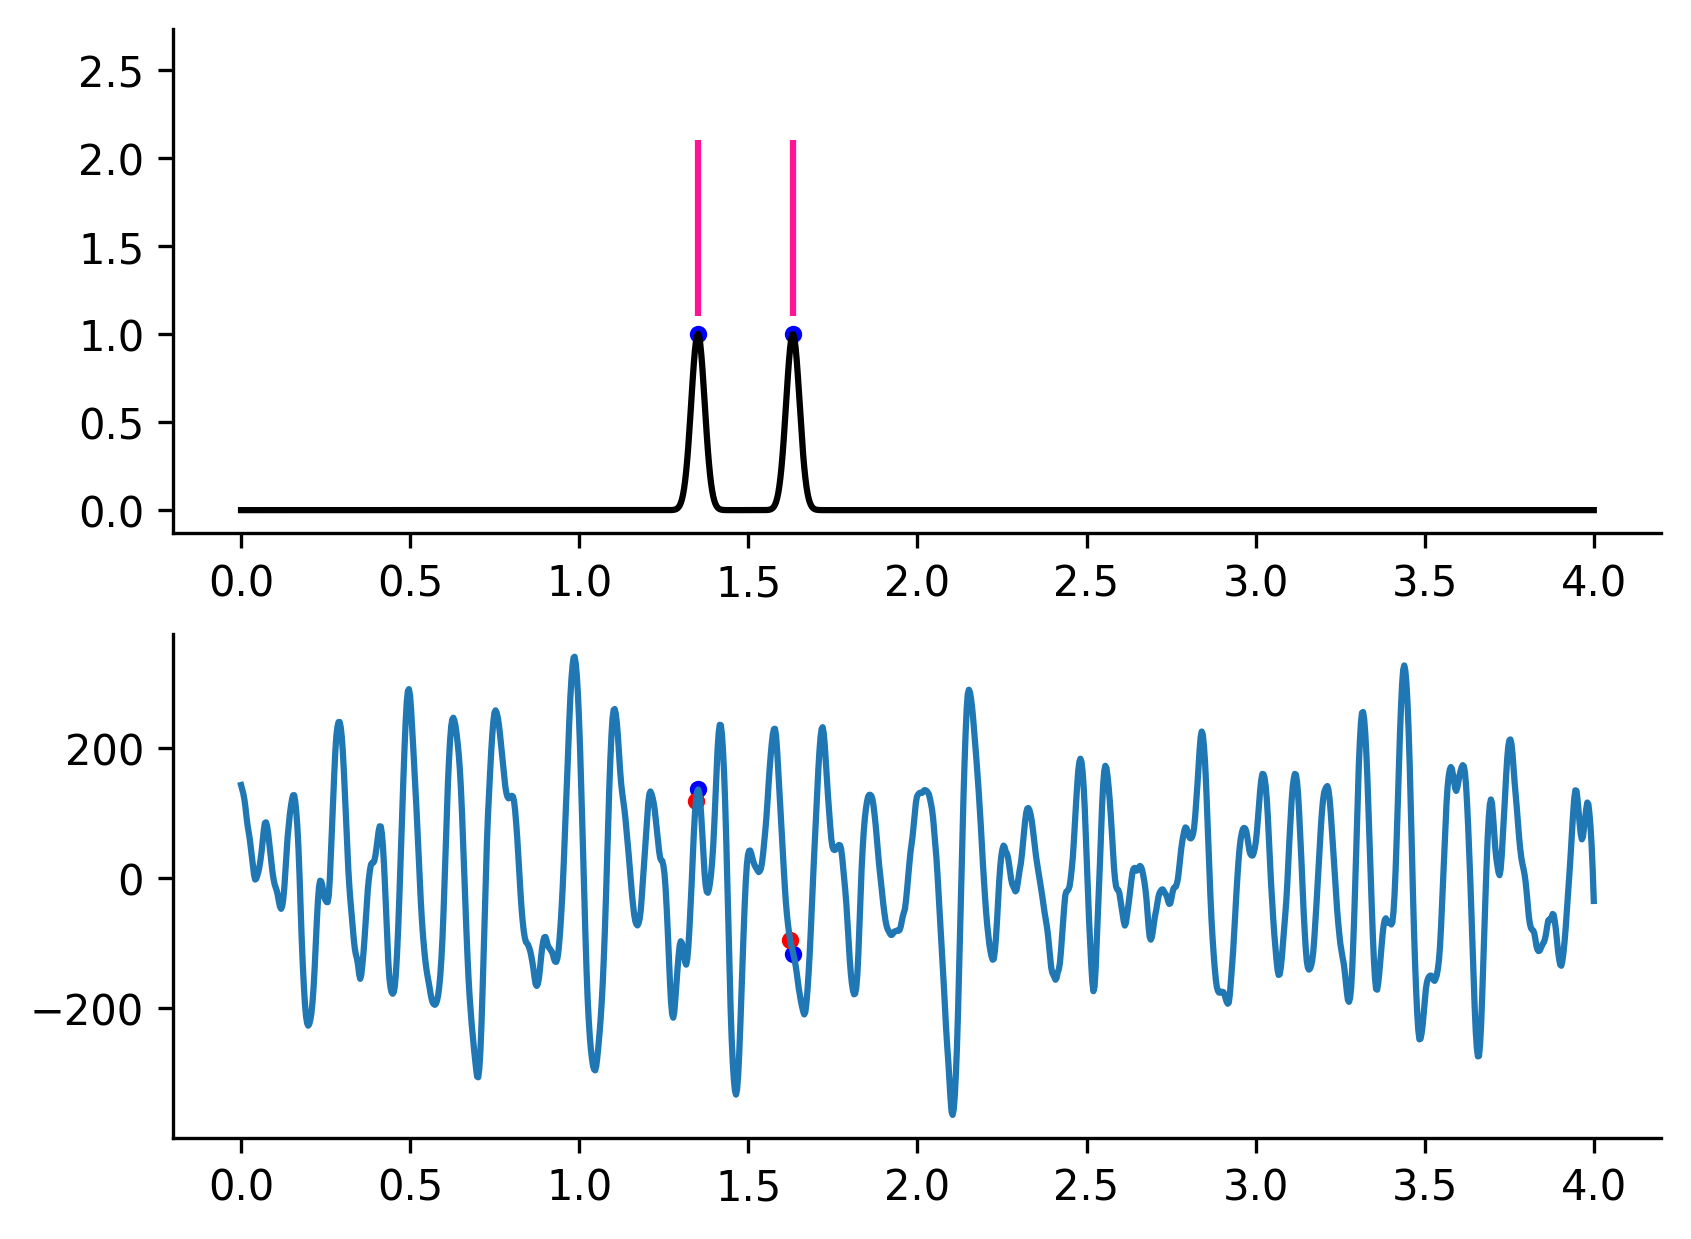

In [35]:
# a posteriori label confirmation
plt.rcParams['figure.dpi'] = 300

# Visualization control parameters  
confirm_supervisor = True
neuron_of_interest = 30
fs = int(X_theta.shape[1]/trial_duration)

# Visualization specific constructs 
time_axis = np.linspace(0, 4, num=X_kde.shape[1])

for trial_row in np.where(np.array(pyr_sep_neuron_labels) == neuron_of_interest)[0]:  #range(X_kde.shape[0]):

    trial_index = int(pyr_sep_trial_labels[trial_row] - 1)

    # Use PRQ algorithm to get cycle central tendencies
    prq, CT_times = compute_PRQ(
        time_axis,
        X_theta[trial_index, :],
        pyr_sep_trials[trial_row],
        fs
    )

    # Determine printoff label from labels
    string_label = 'Null'
    if Y[trial_row, 0] == 1:
        string_label = 'Precession'

    # Printoff neuron information
    print(f'Neuron: {pyr_sep_neuron_labels[trial_row]}, Label: {string_label}')
    print(f'Trial: {pyr_sep_trial_labels[trial_row]}')
    print(f'Trial Index: {trial_index}')

    
    fig, axes = plt.subplots(2, 1)
    fig.patch.set_alpha(0.0)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    peak_indices = find_peaks(X_kde[trial_row, :], height=0.05*np.amax(X_kde[trial_row, :]), distance=0.06*fs)[0]
    theta_oscillation = X_theta[trial_index, :]
    kde = X_kde[trial_row, :]
    axes[0].plot(time_axis, kde, linewidth=1.5, color='k')
    axes[0].scatter(time_axis[peak_indices], kde[peak_indices], s=10, color='b')
    axes[0].eventplot(pyr_sep_trials[trial_row], color='deeppink', lineoffsets=1.6)
    axes[1].plot(time_axis, theta_oscillation, linewidth=1.5)
    axes[1].scatter(time_axis[peak_indices], theta_oscillation[peak_indices], s=10, color='b')
    axes[1].scatter(time_axis[np.array([int(x*fs) for x in CT_times])], theta_oscillation[np.array([int(x*fs) for x in CT_times])], s=10, color='r')

    plt.show()
